In [34]:
import os
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

## Get a partial Return metrics from time series Success Rate data
The starting point 0 is after the random buffer filling 1040steps. Therfore, the initial point is $t_{1040}$ and the raw file logs success rate per every 10,000. Because the lack of the raw return data, we need to estimate the return value via getting differential from previous step to next step. To get this we need to set two equation such that:
$$ succ_{t} = \frac{y}{10000t + 1040}, \quad succ_{t+1} = \frac{y+y'}{10000(t + 1) + 1040}$$ 
Hence, the $ \Delta succ $ can be calculated as follows:
$$ \Delta succ_{t+1} = \frac{y' - \frac{10000y}{10000t + 1040}}{10000(t + 1) + 1040}, (t \ge 0)$$
Then we can get y' from difference of success rate and the time, which is:
$$ y' = (10000(t+1) + 1040)\Delta succ_{t+1} + \frac{10000y}{10000t + 1040} $$  

In [208]:
path = os.getcwd() + "/seed0/"
dataframes = []
file_pathes = []
for (_, _, file) in os.walk(path):
    file_pathes.extend(file)

for file_path in file_pathes:
    dataframes.append(pd.read_csv(path+file_path))

dataframe_lengths = [len(df.index) for df in dataframes]
print(f"DataFrame Lengthes: {dataframe_lengths}")
min_len = min(dataframe_lengths)
print(f"min dataframe length: {min_len}")
modified_dataframes = [df.drop(index=[i for i in range(min_len, df_len)]) for (df, df_len) in zip(dataframes, dataframe_lengths)]
modified_dataframes_drop_min_and_max = [df.drop(df.columns[[2, 3]], axis=1) for df in modified_dataframes]
modified_dataframe_lengths = [len(df.index) for df in modified_dataframes]
print(f"Modified(exceeding min dataframe length has been dropped) Lengths: {modified_dataframe_lengths}")
modified_df_merged = reduce(lambda left,right: pd.merge(left, right, on=["Step"], how="outer"), modified_dataframes_drop_min_and_max) / 100
modified_df_merged = modified_df_merged.drop("Step", axis=1)
delta_success = modified_df_merged.diff().drop(index=0, axis=1)

# print("MODIFIED DF MERGED")
# print(modified_df_merged)
# print("SOMETHING ELSE")
# print(delta_success)
initial_y =  modified_df_merged.loc[0] * 1040
print("INITIAL_Y")
print(initial_y)

DataFrame Lengthes: [177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 179, 180, 180, 180, 181, 181]
min dataframe length: 177
Modified(exceeding min dataframe length has been dropped) Lengths: [177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
INITIAL_Y
hopeful-night-223 - eval/Achievements/place_stone              0.000000
hopeful-night-223 - eval/Achievements/collect_sapling        445.714291
hopeful-night-223 - eval/Achievements/place_furnace            0.000000
hopeful-night-223 - eval/Achievements/make_iron_sword          0.000000
hopeful-night-223 - eval/Achievements/place_table            297.142854
hopeful-night-223 - eval/Achievements/defeat_zombie            0.000000
hopeful-night-223 - eval/Achievements/make_iron_pickaxe        0.000000
hopeful-night-223 - eval/Achievements/defeat_skeleton          0.000000
hopeful-night-223 - eval/Achievements/place_plant            445.714291
hopeful

In [209]:
differential_dfs = []
differential_dfs.append(initial_y)
for i in range(len(delta_success.index)):
    differential_df = (10000*(i+1) + 1040) * delta_success.loc[i+1] + ((10000 * differential_dfs[-1]) / (10000*(i) + 1040))
    print("-------------------------")
    print(differential_df.sum(axis=0))
    print(differential_dfs[-1].sum(axis=0))
    differential_dfs.append(differential_df + differential_dfs[-1])


-------------------------
23021.482544517516
2971.428572845459
-------------------------
8826.80762400627
25992.911117362975
-------------------------
2615.4568388462058
34819.718741369245
-------------------------
1246.2047479629516
37435.17558021545
-------------------------
3475.0751194477098
38681.380328178406
-------------------------
3951.716300606722
42156.45544762611
-------------------------
1526.5374507188774
46108.17174823283
-------------------------
1249.1378899335916
47634.70919895172
-------------------------
1406.454613733289
48883.847088885304
-------------------------
2179.0231891632034
50290.30170261859
-------------------------
2236.5992576837525
52469.3248917818
-------------------------
1473.671042644988
54705.92414946554
-------------------------
1767.7412807345313
56179.59519211053
-------------------------
1230.2872189760253
57947.33647284507
-------------------------
2454.5844567537247
59177.62369182109
-------------------------
848.6894130528008
61632.2081485

In [217]:
elems = []

for idx, df in enumerate(differential_dfs):
    if idx % 10 == 0:
        val = df.sum(axis=0)
        if idx == 0:
            elems.append(val)
        else:
            elems.append(val - elems[-1])

print(elems)

[2971.428572845459, 49497.89631893634, 18172.429755264515, 135619.74763918517, 121773.83642383211, 249094.0107952446, 291874.55909806467, 416462.88202384417, 471933.983790615, 615738.5377097366, 682095.4100610408, 805137.4048559066, 889272.5312766783, 1015690.4353425571, 1087946.829785142, 1229400.6386846742, 1309706.239208655, 1417850.8356639724]


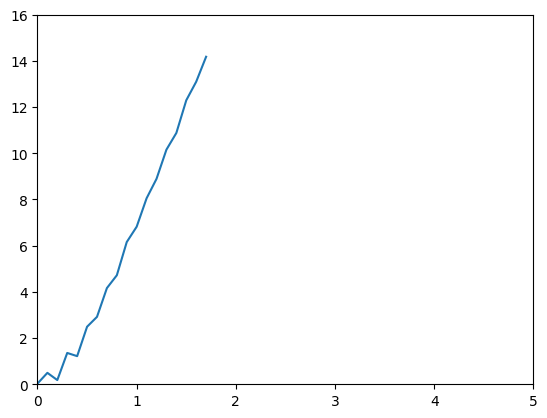

In [224]:
plt.xlim(0, 5)
plt.ylim(0, 16)
plt.plot(0.1*np.arange(0, 18), np.array(elems) /100000) #